In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


## Load the data: [Captcha Images](https://www.kaggle.com/fournierp/captcha-version-2-images)
Let's download the data.

In [ ]:
!curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
!unzip -qq captcha_images_v2.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 8863k  100 8863k    0     0  5800k      0  0:00:01  0:00:01 --:--:-- 22.4M
replace captcha_images_v2/ydd3g.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

The dataset contains 1040 captcha files as `png` images. The label for each sample is a string,
the name of the file (minus the file extension).
We will map each character in the string to an integer for training the model. Similary,
we will need to map the predictions of the model back to strings. For this purpose
we will maintain two dictionaries, mapping characters to integers, and integers to characters,
respectively.

In [ ]:

# Path to the data directory
data_dir = Path("./captcha_images_v2/")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])


Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  {'6', 'm', 'b', 'w', 'f', '3', 'g', 'd', 'e', '4', 'x', '5', 'y', '2', 'c', '8', '7', 'n', 'p'}


## Preprocessing

In [ ]:

# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}


In [ ]:
with open("vocab.txt", "w") as output:
    for item in char_to_num.get_vocabulary():
        output.write(item+"\n")

## Create `Dataset` objects

In [ ]:

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

## Visualize the data

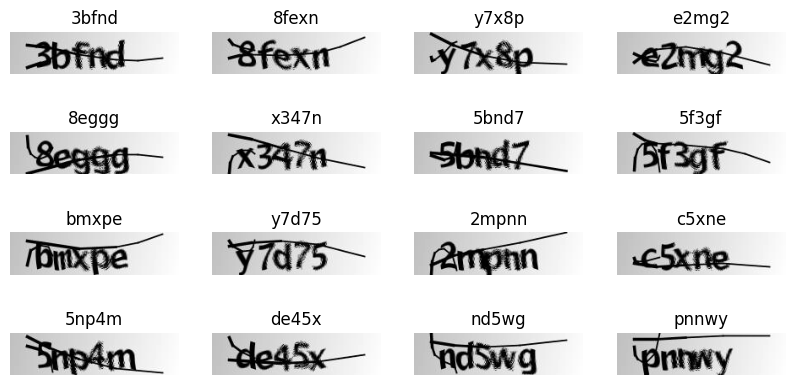

In [ ]:

_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

## Model

In [ ]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)        │ (None, 200, 50, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 200, 50, 32)    │            320 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 100, 25, 32)    │              0 │ Conv1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv2 (Conv2D)            │ (None, 100, 25, 64)    │         18,496 │ pool1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool2 (MaxPooling2D)      │ (None, 50, 12, 64)     │              0 │ Conv2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 50, 768)        │              0 │ pool2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense1 (Dense)            │ (None, 50, 64)         │         49,216 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_25 (Dropout)      │ (None, 50, 64)         │              0 │ dense1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_50          │ (None, 50, 256)        │        197,632 │ dropout_25[0][0]       │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_51          │ (None, 50, 128)        │        164,352 │ bidirectional_50[0][0] │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ label (InputLayer)        │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense2 (Dense)            │ (None, 50, 21)         │          2,709 │ bidirectional_51[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ctc_loss (CTCLayer)       │ (None, 50, 21)         │              0 │ label[0][0],           │
│                           │                        │                │ dense2[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 432,725 (1.65 MB)

 Trainable params: 432,725 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

## Training

In [ ]:
epochs = 300
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[tracker, early_stopping]
)

Epoch 1/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - loss: 591.5828 - val_loss: 252.2293
Epoch 2/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 262.0211 - val_loss: 252.2803
Epoch 3/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 261.7183 - val_loss: 251.7885
Epoch 4/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 261.4291 - val_loss: 251.8744
Epoch 5/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 261.4697 - val_loss: 251.2881
Epoch 6/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 261.1778 - val_loss: 251.3557
Epoch 7/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 261.2819 - val_loss: 251.3471
Epoch 8/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 261.2005 - val_loss: 251.1028
Epoch 9/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 261.0594 - val_loss: 250.6879
Epoch 10/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 260.8846 - val_loss: 251.1304
Epoch 11/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 260.8117 - val_loss: 250.5952
Epoch 1

## Inference

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)                   │ (None, 200, 50, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1 (Conv2D)                       │ (None, 200, 50, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 100, 25, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv2D)                       │ (None, 100, 25, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 50, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 50, 768)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense1 (Dense)                       │ (None, 50, 64)              │          49,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 50, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_50 (Bidirectional)     │ (None, 50, 256)             │         197,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_51 (Bidirectional)     │ (None, 50, 128)             │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense2 (Dense)                       │ (None, 50, 21)              │           2,709 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 432,725 (1.65 MB)

 Trainable params: 432,725 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


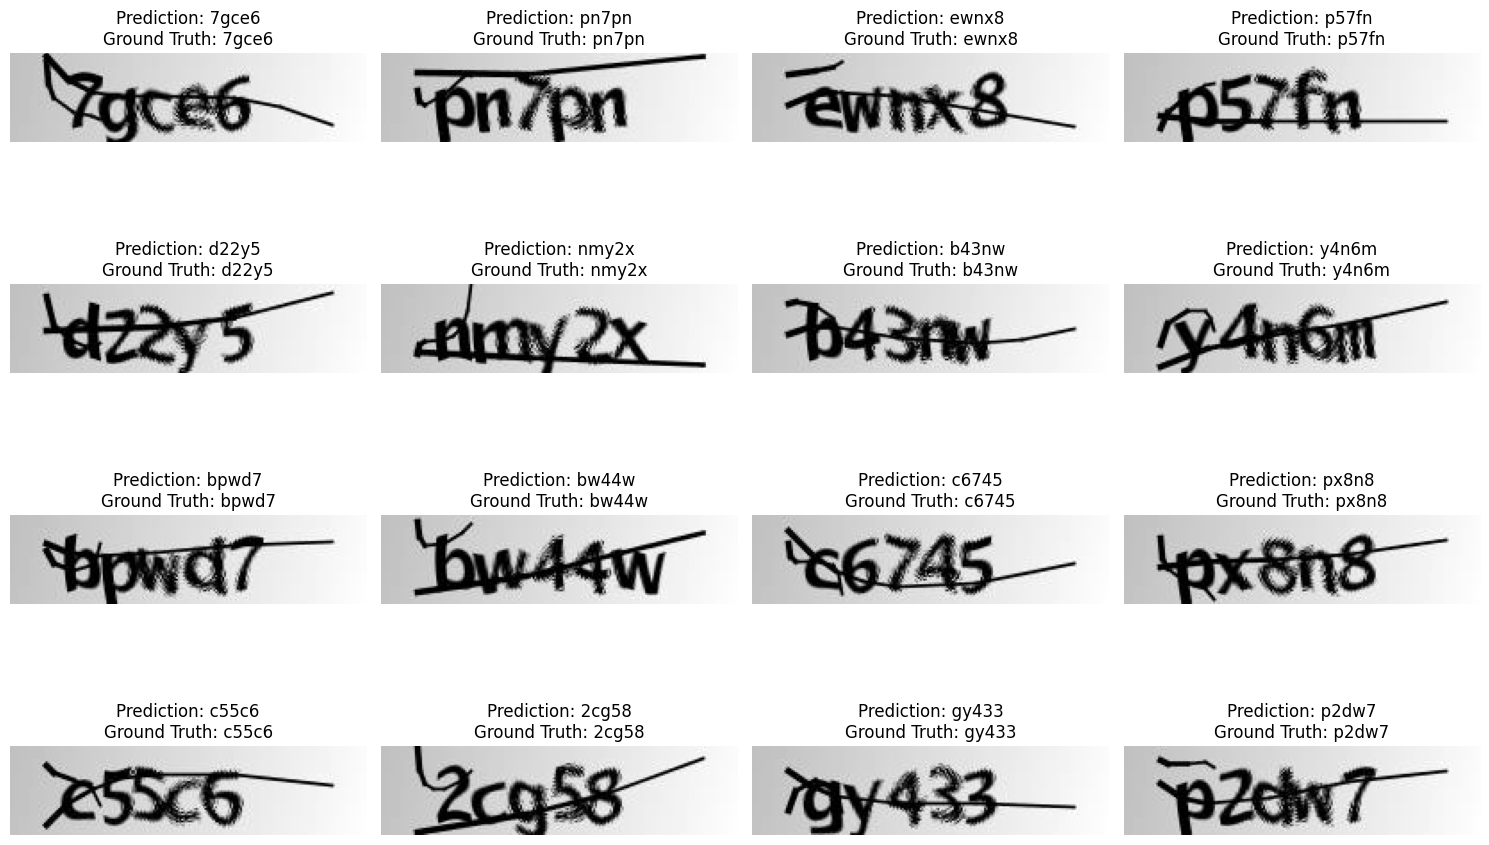

In [ ]:
# Extract the input and dense output layers for prediction
input_img = model.input[0]  # Input tensor for the images
output = model.get_layer(name="dense2").output  # Output tensor before CTC loss

# Define the prediction model
prediction_model = keras.models.Model(inputs=input_img, outputs=output)
prediction_model.summary()

# Utility function to decode batch predictions
def decode_batch_predictions(predictions):
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    decoded_results = keras.backend.ctc_decode(predictions, input_length=input_len, greedy=True)[0][0][:, :max_length]

    decoded_texts = []
    for res in decoded_results:
        text = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        decoded_texts.append(text)
    return decoded_texts

# Check results on validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    # Predict using the prediction model
    predictions = prediction_model.predict(batch_images)
    predicted_texts = decode_batch_predictions(predictions)

    # Convert ground truth labels to text
    original_texts = [tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8") for label in batch_labels]

    # Plot predictions and original images
    fig, axes = plt.subplots(4, 4, figsize=(15, 10))
    axes = axes.flatten()

    for i, ax in enumerate(axes[:len(predicted_texts)]):
        img = (batch_images[i].numpy().squeeze() * 255).astype(np.uint8).T
        ax.imshow(img, cmap="gray")
        ax.set_title(f"Prediction: {predicted_texts[i]}\nGround Truth: {original_texts[i]}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:

prediction_model.save("/content/drive/MyDrive/Colab Notebooks/TensorGo/models/ocr_prediction_model.h5")

In [ ]:
# Save in the recommended Keras format
prediction_model.save("/content/drive/MyDrive/Colab Notebooks/TensorGo/models/ocr_prediction_model.keras")


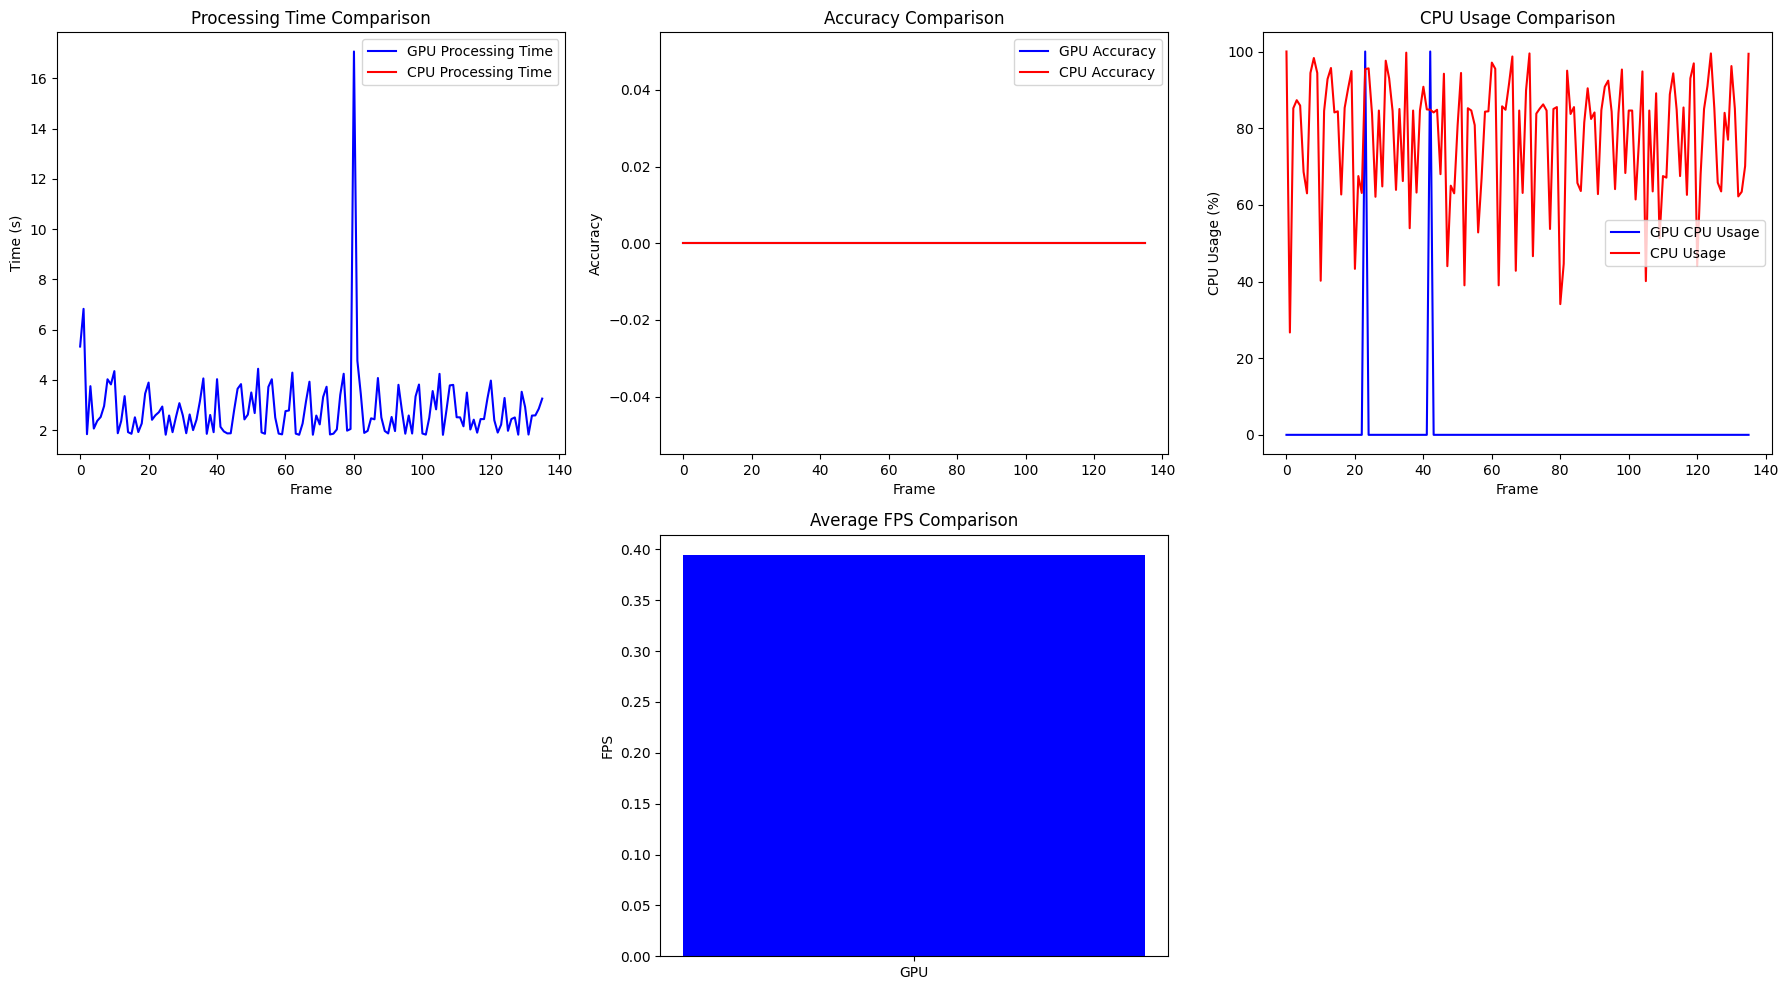

Performance Evaluation:
FPS (GPU): 0.39
FPS (CPU): nan
Average CPU Usage (GPU mode): 1.47%
Average CPU Usage (CPU mode): 77.72%


In [ ]:
def calculate_fps(self):
    # Ensure frame times are not too small
    frame_times_gpu = [t for t in self.frame_times_gpu if t > 1e-6]  # Filter out zero or near-zero times
    frame_times_cpu = [t for t in self.frame_times_cpu if t > 1e-6]  # Filter out zero or near-zero times

    fps_gpu = np.mean([1 / t for t in frame_times_gpu]) if frame_times_gpu else 0
    fps_cpu = np.mean([1 / t for t in frame_times_cpu]) if frame_times_cpu else 0

    return fps_gpu, fps_cpu


# Calculate FPS (Frames Per Second)
fps_gpu, fps_cpu = tracker.calculate_fps()

# Filter out 'nan' values in the frame times for plotting
frame_times_gpu_filtered = [t for t in tracker.frame_times_gpu if not np.isnan(t)]
frame_times_cpu_filtered = [t for t in tracker.frame_times_cpu if not np.isnan(t)]

# Plot the performance comparison
plot_performance_comparison(
    frame_times_gpu_filtered, tracker.accuracies_gpu, frame_times_cpu_filtered, tracker.accuracies_cpu,
    tracker.cpu_usages_gpu, tracker.cpu_usages_cpu, tracker.gpu_usages, fps_gpu, fps_cpu
)

# Print the performance evaluation
print("Performance Evaluation:")
print(f"FPS (GPU): {fps_gpu:.2f}")
print(f"FPS (CPU): {fps_cpu:.2f}")
print(f"Average CPU Usage (GPU mode): {np.mean(tracker.cpu_usages_gpu):.2f}%")
print(f"Average CPU Usage (CPU mode): {np.mean(tracker.cpu_usages_cpu):.2f}%")


## Metrics

In [ ]:
import time
import psutil
import tensorflow as tf

# Function to monitor resource usage
def get_resource_usage():
    cpu_usage = psutil.cpu_percent()
    memory_usage = psutil.virtual_memory().percent
    return cpu_usage, memory_usage

# Evaluate training on GPU
with tf.device('/GPU:0'):
    start_time = time.time()
    history_gpu = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=epochs,
        callbacks=[early_stopping],
    )
    gpu_time = time.time() - start_time
    gpu_cpu, gpu_memory = get_resource_usage()
    print(f"GPU Time: {gpu_time:.2f} seconds")
    print(f"GPU CPU Usage: {gpu_cpu}% | GPU Memory Usage: {gpu_memory}%")

# Evaluate inference on GPU
with tf.device('/GPU:0'):
    start_time = time.time()
    for batch in validation_dataset.take(1):
        batch_images = batch["image"]
        preds = prediction_model.predict(batch_images)
    gpu_inference_time = time.time() - start_time

# Evaluate training on CPU
with tf.device('/CPU:0'):
    start_time = time.time()
    history_cpu = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=epochs,
        callbacks=[early_stopping],
    )
    cpu_time = time.time() - start_time
    cpu_cpu, cpu_memory = get_resource_usage()
    print(f"CPU Time: {cpu_time:.2f} seconds")
    print(f"CPU CPU Usage: {cpu_cpu}% | CPU Memory Usage: {cpu_memory}%")

# Evaluate inference on CPU
with tf.device('/CPU:0'):
    start_time = time.time()
    for batch in validation_dataset.take(1):
        batch_images = batch["image"]
        preds = prediction_model.predict(batch_images)
    cpu_inference_time = time.time() - start_time

# Print inference performance
print(f"GPU Inference Time: {gpu_inference_time:.2f} seconds")
print(f"CPU Inference Time: {cpu_inference_time:.2f} seconds")

Epoch 1/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.8819 - val_loss: 1.1761
Epoch 2/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 1.2234 - val_loss: 1.3882
Epoch 3/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 1.4771 - val_loss: 0.3156
Epoch 4/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.7534 - val_loss: 0.7840
Epoch 5/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 2.0381 - val_loss: 0.3852
Epoch 6/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 1.5275 - val_loss: 1.0079
Epoch 7/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.7729 - val_loss: 0.3328
Epoch 8/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 1.1451 - val_loss: 0.4701
Epoch 9/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 1.2121 - val_loss: 1.4118
Epoch 10/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.7210 - val_loss: 0.9562
GPU Time: 43.41 seconds
GPU CPU Usage: 48.2% | GPU Memory Usage: 25.1%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 1/300
59/59 ━━━━━━━━━━━━

In [ ]:
# Load the Keras model
model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/TensorGo/ocr_prediction_model.keras")

# Convert the Keras model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert and save the TFLite model
converter.experimental_new_converter = True
converter.allow_custom_ops = True
tflite_model = converter.convert()

with open("ocr_model_quantized.tflite", "wb") as f:
    f.write(tflite_model)

print("TFLite model successfully saved as 'ocr_model_quantized.tflite'")


Saved artifact at '/tmp/tmp802gtdyp'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 200, 50, 1), dtype=tf.float32, name='image')
Output Type:
  TensorSpec(shape=(None, 50, 21), dtype=tf.float32, name=None)
Captures:
  137448443333616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137448443338368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137448443345760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137448443429984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137448443435792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137448443432448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137448443472080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137448443475072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137448443477008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137448443472784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137448443464864: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


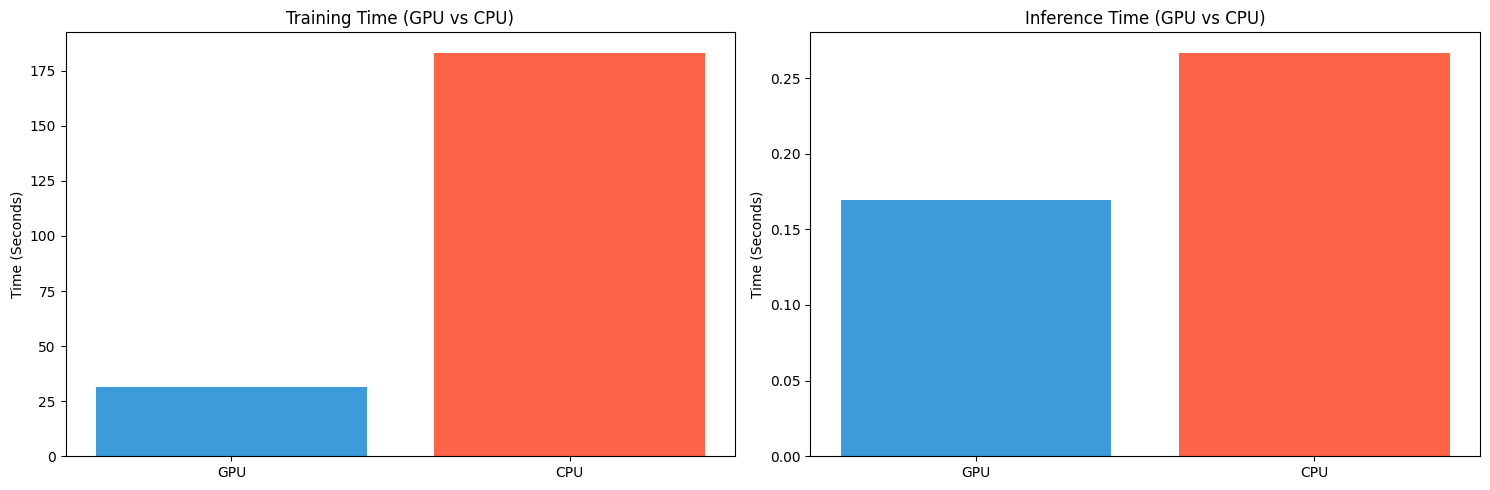

In [ ]:
import matplotlib.pyplot as plt

# Collect data
device_labels = ['GPU', 'CPU']
train_times = [gpu_time, cpu_time]
inference_times = [gpu_inference_time, cpu_inference_time]

# Create a bar graph for comparison
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot training time comparison
ax[0].bar(device_labels, train_times, color=['#3b9bdb', '#ff6347'])
ax[0].set_title('Training Time (GPU vs CPU)')
ax[0].set_ylabel('Time (Seconds)')

# Plot inference time comparison
ax[1].bar(device_labels, inference_times, color=['#3b9bdb', '#ff6347'])
ax[1].set_title('Inference Time (GPU vs CPU)')
ax[1].set_ylabel('Time (Seconds)')

plt.tight_layout()
plt.show()